# **BPM Prediction Challenge**

### Steps:
1. Feature Engineering
2. Model Implementation

In [ ]:
!pip install xgboost

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, PolynomialFeatures
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


In [ ]:
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [ ]:
test.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


In [ ]:
#No null values and data types are accurate
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB


In [ ]:
#No duplicates
train.duplicated().sum()

0

In [ ]:
train.describe()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257586,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


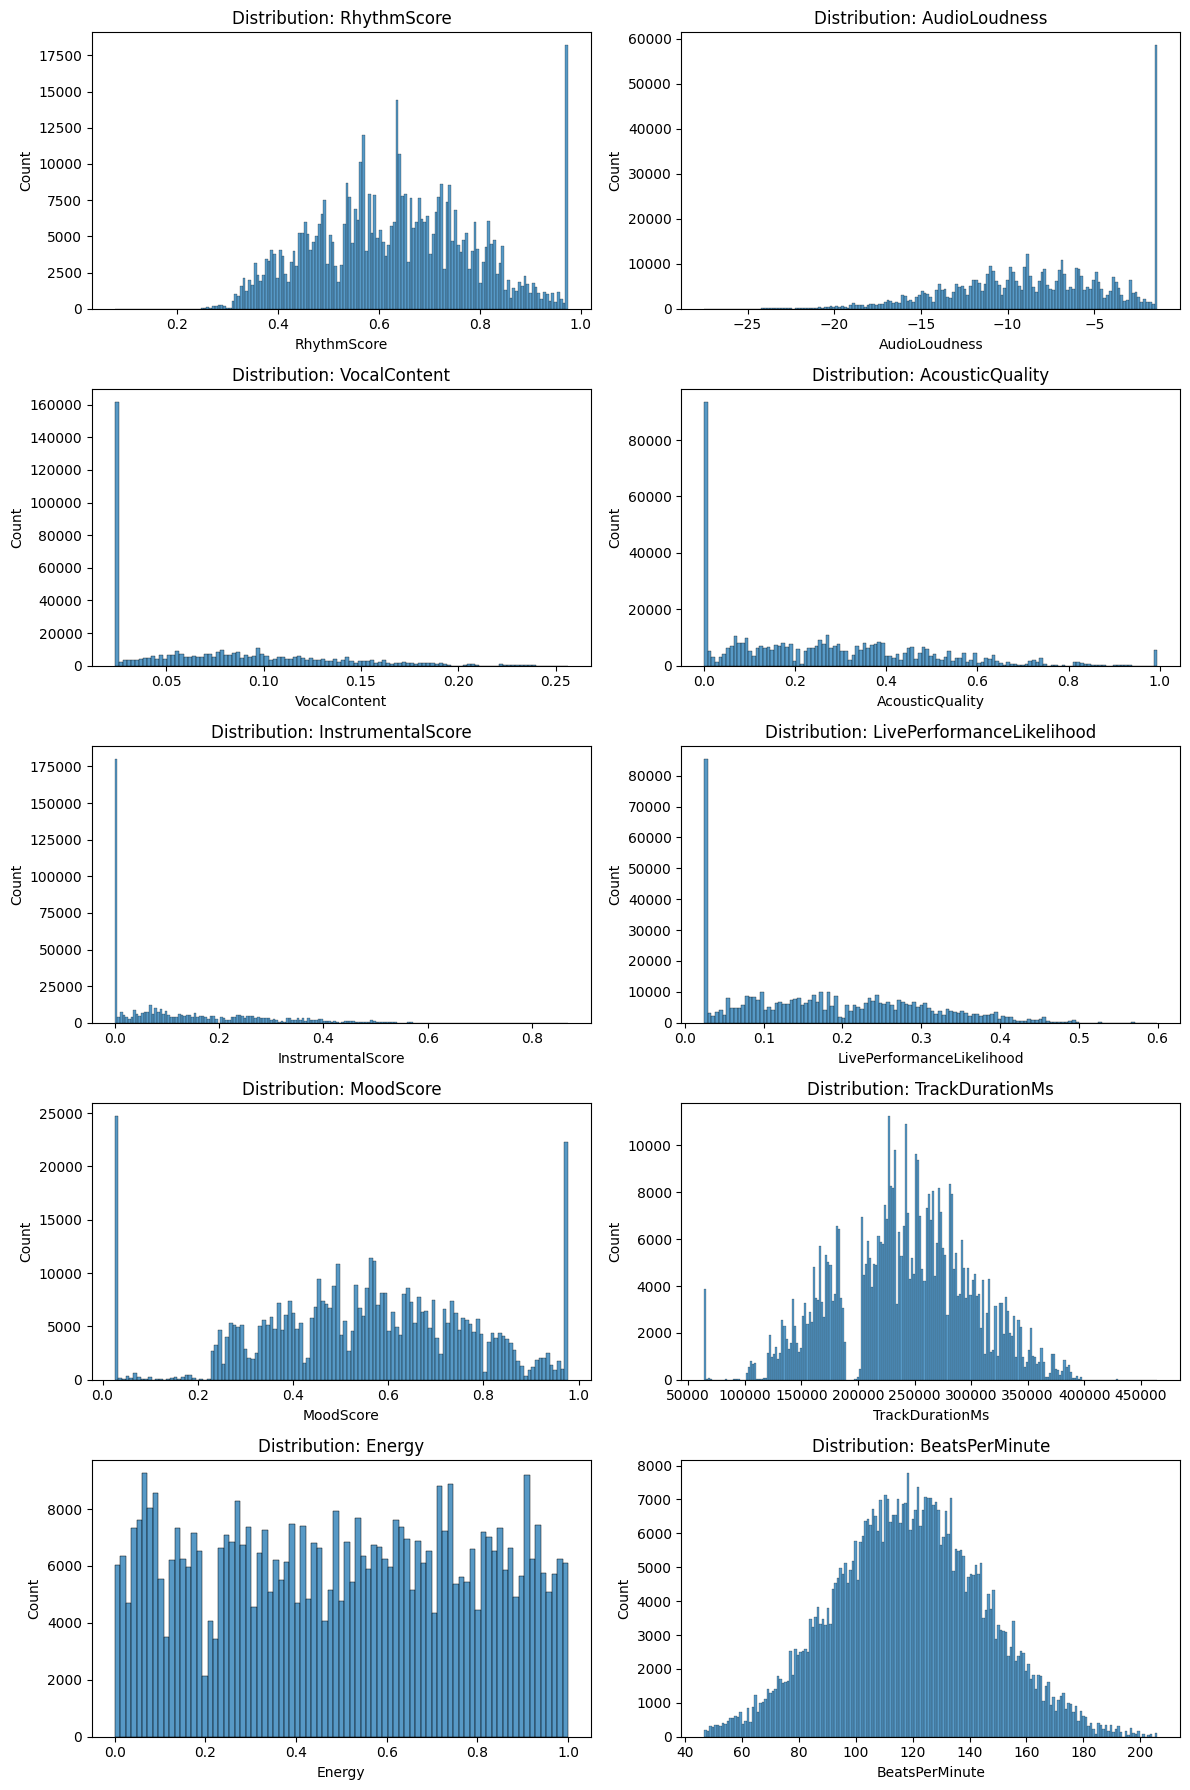

In [ ]:
#Visualizing the distribution for each column in the data
fig, axes = plt.subplots(nrows = 5,ncols = 2, figsize = (12,18))
axes = axes.flatten()
cols = train.columns[1:]
for i in range(len(cols)):
    sns.histplot(x = train[cols[i]], ax = axes[i])
    axes[i].set_title("Distribution: " + cols[i])

plt.tight_layout()
plt.show()

# Correlation between numerical values

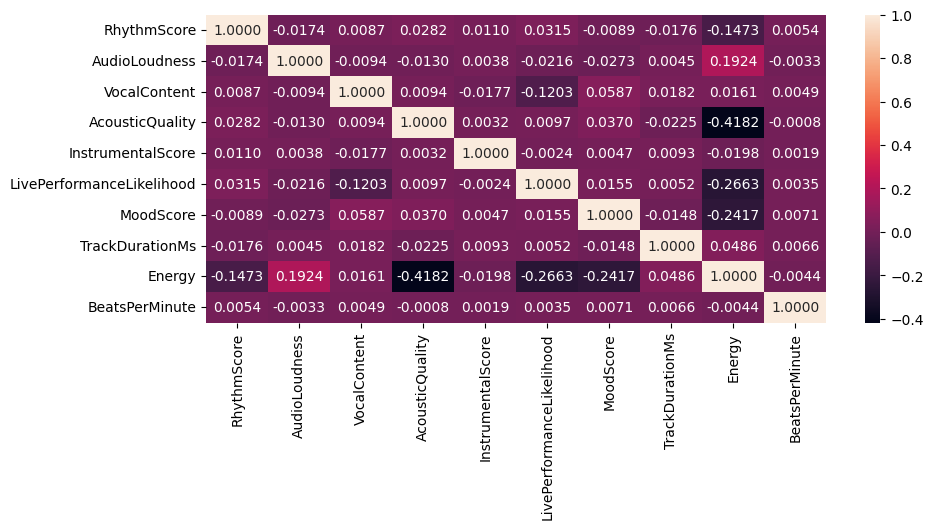

In [ ]:
plt.figure(figsize = (10,4))
sns.heatmap(data = train.iloc[:,1:].corr(),cmap = "rocket", fmt = ".4f", annot = True)
plt.show()

# Creating a Polynomial Regression model on the original data (Without feature engineering)

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias = False)

x,y = train[[col for col in train.columns if col not in ['BeatsPerMinute','id']]], train['BeatsPerMinute']
x_poly = poly.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(x_poly, y, test_size = 0.25, random_state = 47)

model_poly = LinearRegression()
model_poly.fit(x_poly, y)
ypred = model_poly.predict(x_poly)
np.sqrt(mean_squared_error(ypred, y))

26.46335456815243

In [ ]:
#Since the Polynomial regression model with degree 2 works well, let us create a submission with it
test_data = test.iloc[:, 1:]
test_data = poly.fit_transform(test_data)
test_predictions = model_poly.predict(test_data)
output_data = {
    'id': test.iloc[:,0],
    'BeatsPerMinute': test_predictions
}
output = pd.DataFrame(output_data)
output.head()

output.to_csv("submission_pr.csv", index = False)

### Submission RMSE - 26.39430

# Feature Engineering

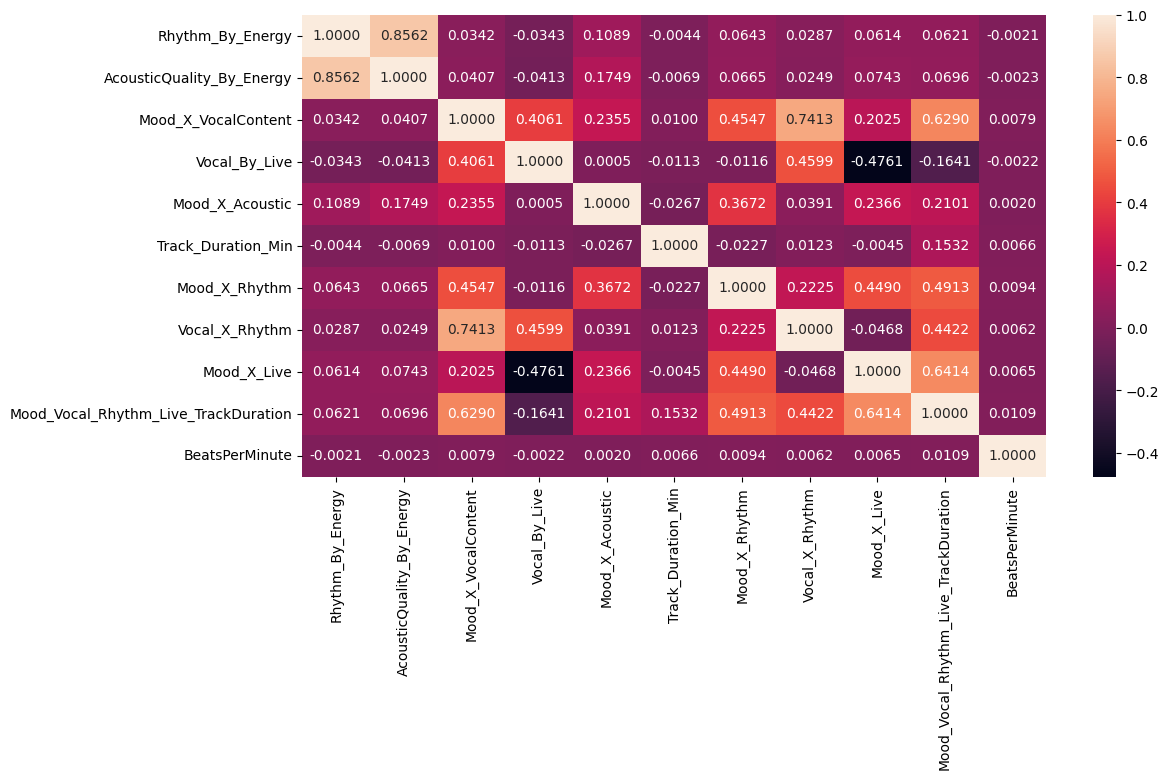

In [ ]:
#Feature Engineering to create new columns and identifying correlation with the target
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")

train['Rhythm_By_Energy'] = train['RhythmScore'] / train['Energy']
train['AcousticQuality_By_Energy'] = train['AcousticQuality'] / train['Energy']
train['Mood_X_VocalContent'] = train['MoodScore'] * train['VocalContent']
train['Vocal_By_Live'] = train['VocalContent'] / train['LivePerformanceLikelihood']
train['Mood_X_Acoustic'] = train['MoodScore'] * train['AcousticQuality']
train['Track_Duration_Min'] = train['TrackDurationMs'] / 60000 #Since the data is in milliseconds, = MS/1000*60 for minutes
train['Mood_X_Rhythm'] = train['MoodScore'] * train['RhythmScore']
train['Vocal_X_Rhythm'] = train['VocalContent'] * train['RhythmScore']
train['Mood_X_Live'] = train['LivePerformanceLikelihood'] * train['MoodScore']
train['Mood_Vocal_Rhythm_Live_TrackDuration'] = train['MoodScore']**2 * train['RhythmScore'] * train['VocalContent'] * train['LivePerformanceLikelihood'] * train['Track_Duration_Min']

plt.figure(figsize = (12,6))
sns.heatmap(data = train[['Rhythm_By_Energy','AcousticQuality_By_Energy','Mood_X_VocalContent','Vocal_By_Live','Mood_X_Acoustic','Track_Duration_Min','Mood_X_Rhythm','Vocal_X_Rhythm','Mood_X_Live','Mood_Vocal_Rhythm_Live_TrackDuration','BeatsPerMinute']].corr(),cmap = "rocket", fmt = ".4f", annot = True)
plt.show()

# Model Training and Testing

In [ ]:
[col for col in train.columns if col not in ['BeatsPerMinute','id','TrackDurationMs']]

['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'Energy',
 'Rhythm_By_Energy',
 'AcousticQuality_By_Energy',
 'Mood_X_VocalContent',
 'Vocal_By_Live',
 'Mood_X_Acoustic',
 'Track_Duration_Min',
 'Mood_X_Rhythm',
 'Vocal_X_Rhythm',
 'Mood_X_Live',
 'Mood_Vocal_Rhythm_Live_TrackDuration']

In [ ]:
# Splitting the data into train and test from the train.csv itself
x,y = train[[col for col in train.columns if col not in ['BeatsPerMinute','id','TrackDurationMs']]], train['BeatsPerMinute']
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 47)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(393123, 18) (131041, 18) (393123,) (131041,)


In [ ]:
#Fitting multiple models and checking the best performance as an initial training check
models = {
    'LinearRegression': LinearRegression(),
    'Lasso':Lasso(random_state = 47),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state = 47),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor':RandomForestRegressor(n_estimators = 10,random_state = 47),
    'AdaBoostRegressor':AdaBoostRegressor(n_estimators = 10,random_state = 47),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators = 10,random_state = 47),
    'XGBoostRegressor': XGBRegressor(n_estimators = 10,random_state = 47),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators = 10, random_state = 47),
    'LGBM': lgb.LGBMRegressor(random_state= 47, verbose = -1)
}

best_rmse = 1000
best_model = None

for name, model in models.items():
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    error = np.sqrt(mean_squared_error(ytest, ypred))

    print(f"{name} RMSE: {error}")

    if best_rmse >error:
        best_rmse = error
        best_model = name

print(f"\nBest Model: {best_model}, Best RMSE: {best_rmse}")

LinearRegression RMSE: 26.47545432921521
Lasso RMSE: 26.475225098898438
DecisionTreeRegressor RMSE: 38.20944649900143
KNeighborsRegressor RMSE: 28.961803484718477
RandomForestRegressor RMSE: 27.993013362581546
AdaBoostRegressor RMSE: 26.47734201319165
GradientBoostingRegressor RMSE: 26.46927510592733
XGBoostRegressor RMSE: 26.478029817475047
ExtraTreesRegressor RMSE: 28.04321352794853
LGBM RMSE: 26.471455661587065

Best Model: GradientBoostingRegressor, Best RMSE: 26.46927510592733


# Hyperparameter Tuning on the Lasso

In [ ]:
#Lasso for feature selection
names = [col for col in train.columns if col not in ['id','BeatsPerMinute','TrackDurationMs']]

def lasso(alpha):
    df1 = pd.DataFrame()
    df1['FeatureNames'] = names
    for i in alpha:
        lasso = Lasso(alpha = i)
        lasso.fit(x,y)
        col_name = "Alpha = %f"%i
        df1[col_name] = lasso.coef_

    return df1

lasso([0.0001,0.001,0.01,0.1,0.5,1,10,100])

,FeatureNames,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.010000,Alpha = 0.100000,Alpha = 0.500000,Alpha = 1.000000,Alpha = 10.000000,Alpha = 100.000000
0,RhythmScore,-0.000000,0.071395,0.000000,0.0,0.0,0.0,0.0,0.0
1,AudioLoudness,-0.419381,-0.376787,-0.112197,-0.0,-0.0,-0.0,-0.0,-0.0
2,VocalContent,1.058528,0.565238,0.351464,0.0,0.0,0.0,0.0,0.0
3,AcousticQuality,-0.022753,-0.029735,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0
4,InstrumentalScore,0.320114,0.282989,0.000000,0.0,0.0,0.0,0.0,0.0
5,LivePerformanceLikelihood,0.183067,0.000000,0.193791,0.0,0.0,0.0,0.0,0.0
6,MoodScore,-0.397852,-0.099730,0.000000,0.0,0.0,0.0,0.0,0.0
7,Energy,-0.160814,-0.109974,-0.080323,-0.0,-0.0,-0.0,-0.0,-0.0
8,Rhythm_By_Energy,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0
9,AcousticQuality_By_Energy,-14.670896,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0


In [ ]:
#Selecting best alpha for Lasso
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
x = train[['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'Energy', 'Rhythm_By_Energy',
       'AcousticQuality_By_Energy', 'Vocal_By_Live',
       'Mood_X_Acoustic', 'Mood_X_Rhythm',
       'Mood_Vocal_Rhythm_Live_TrackDuration']]
model1 = Lasso()
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)
params = {'alpha':[0.001,0.01,0.1,0.5,1,10]}
grid = GridSearchCV(model1, params, cv = cv)
results = grid.fit(x,y)
print(results.best_params_, results.best_estimator_)

{'alpha': 0.001} Lasso(alpha=0.001)


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 47)
lasso_model = Lasso(alpha = 0.001)
lasso_model.fit(x, y)
ypred = lasso_model.predict(x)

np.sqrt(mean_squared_error(y, ypred))

26.46576769511532

# Creating a Stacking Regressor - Using the tuned models in this one with Linear, Lasso, GBM & LightGBM

In [ ]:
#Defining a function to create a stacking model
x,y = train[[col for col in train.columns if col not in ['BeatsPerMinute','id','TrackDurationMs']]], train['BeatsPerMinute']

def get_stacking():
  level0 = list()  #Init an empty list to hold all models
  level0.append(('lr',LinearRegression()))
  level0.append(('lasso', Lasso(alpha = 0.001, random_state  = 47)))
  level0.append(('gbm', GradientBoostingRegressor(n_estimators = 10)))
  level0.append(('lightgbm', lgb.LGBMRegressor(random_state= 47, verbose = -1, n_estimators = 10)))
  level1 = LinearRegression()
  model = StackingRegressor(estimators = level0, final_estimator = level1) #Combine base models and meta models
  return model

smodel = get_stacking()
smodel.fit(x, y)
ypred = smodel.predict(x)
rmse = np.sqrt(mean_squared_error(y, ypred))
print(rmse)

26.44639879824367


In [ ]:
#Feature Engineering to create new columns and identifying correlation with the target
test = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
test['Rhythm_By_Energy'] = test['RhythmScore'] / test['Energy']
test['AcousticQuality_By_Energy'] = test['AcousticQuality'] / test['Energy']
test['Mood_X_VocalContent'] = test['MoodScore'] * test['VocalContent']
test['Vocal_By_Live'] = test['VocalContent'] / test['LivePerformanceLikelihood']
test['Mood_X_Acoustic'] = test['MoodScore'] * test['AcousticQuality']
test['Track_Duration_Min'] = test['TrackDurationMs'] / 60000 #Since the data is in milliseconds, = MS/1000*60 for minutes
test['Mood_X_Rhythm'] = test['MoodScore'] * test['RhythmScore']
test['Vocal_X_Rhythm'] = test['VocalContent'] * test['RhythmScore']
test['Mood_X_Live'] = test['LivePerformanceLikelihood'] * test['MoodScore']
test['Mood_Vocal_Rhythm_Live_TrackDuration'] = test['MoodScore']**2 * test['RhythmScore'] * test['VocalContent'] * test['LivePerformanceLikelihood'] * test['Track_Duration_Min']

In [ ]:
test_data = test[[col for col in test.columns if col not in ['id','TrackDurationMs']]]
test_predictions = smodel.predict(test_data)
output_data = {
    'id': test.iloc[:,0],
    'BeatsPerMinute': test_predictions
}
output = pd.DataFrame(output_data)
output.head()

output.to_csv("submission_smodel2.csv", index = False)

### Submission RMSE - 26.38811. Best Yet
### Leaderboard position at the time of submission - 1024 (Out of 2398)